In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy as sy
from scipy.integrate import odeint

In [2]:
phi,V0 = sp.symbols('phi V0',real =True)


V=V0*(sp.exp(phi)-1)**2
dVdphi = sp.diff(V,phi)
lam = -1/V *dVdphi

lam_simplified = sp.simplify(lam)
print("lam(phi) =", lam_simplified)
print(f"V' = {dVdphi}")

lam(phi) = 2*exp(phi)/(1 - exp(phi))
V' = 2*V0*(exp(phi) - 1)*exp(phi)


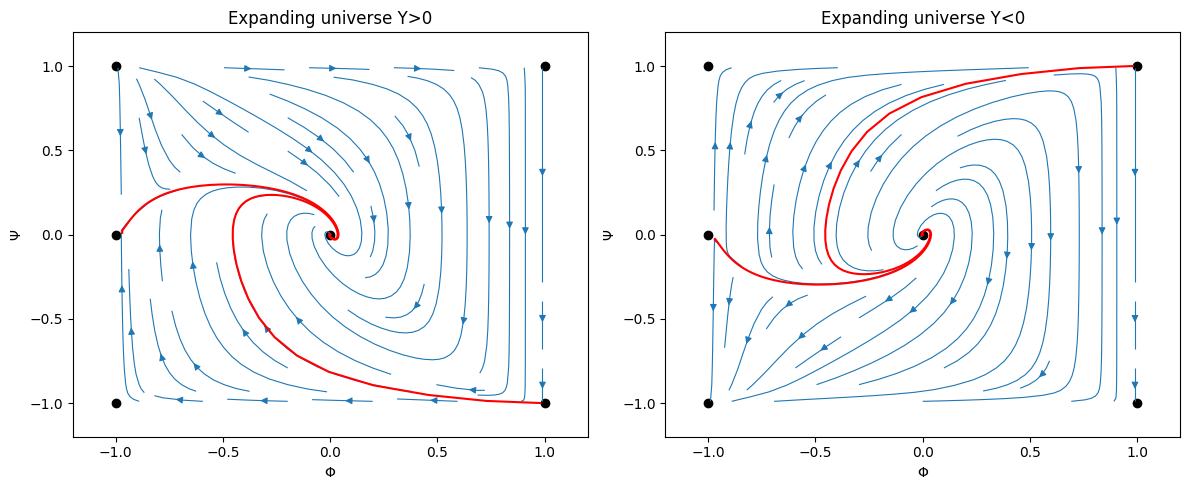

In [3]:
def dynamicsStateSpace(Phi,Psi,Y):
  eps = 1e-6  # avoid sqrt(0)
  Phi = np.clip(Phi, -1+eps,1-eps) # clipping phi and psi to stop |phi| and |psi| blowing up near ==1.
  Psi = np.clip(Psi,-1+eps,1-eps)
  Y = np.clip(Y,-1+eps, 1-eps)

  phi = Phi/np.sqrt(1-Phi**2)
  dPsi = -3*Y*Psi*np.sqrt(1-Psi**2) -2*(1-Psi**2)**1.5 *np.exp(phi)*(np.exp(phi)-1)
  dPhi = (1-Phi**2)**(1.5) *Psi/(np.sqrt(1-Psi**2))
  dY = -Y**2/(np.sqrt(1-Y**2)) -1/3 *( Psi**2/(np.sqrt(1-Psi**2)) -(np.exp(phi)-1)**2)*(1-Y**2/(np.sqrt(1-Y**2)))**(-3/2)
  
  return dPhi,dPsi

# defining a grid of points at which we create/compute tangent arrows
def vector_field_Y(Y):
  Phi = np.linspace(-0.99,0.99,30)# FP occur on hte boundary which relate to points going to infinity
  Psi = np.linspace(-0.99,0.99,30)
  PHI,PSI = np.meshgrid(Phi,Psi)
  dPHI = np.zeros(PHI.shape)
  dPSI = np.zeros(PSI.shape)

  for i in range(PHI.shape[0]): 
      for j in range(PHI.shape[1]): 
              a,b = dynamicsStateSpace(PHI[i,j], PSI[i,j],Y)
              dPHI[i,j] = a
              dPSI[i,j] = b
  return PHI,PSI,dPHI,dPSI
      

# Y>0 expanding, Y<0 contracting plots
def detect_FP(Y,temp=1e-4):
   grid =np.linspace(-0.99,0.99,30)
   FPs=[]

   for Phi in grid:
      for Psi in grid:
              dPhi,dPsi = dynamicsStateSpace(Phi, Psi,Y)
              norm = np.sqrt(dPhi**2 + dPsi**2)

              boundary = (abs(abs(Phi)-1) < 0.015 or abs(abs(Psi)-1) < 0.015)


              if norm<temp or boundary:
                 p = np.array([Phi, Psi])
                 if not any(np.linalg.norm(p-q) < 0.2 for q in FPs):
                    FPs.append(p)

   return np.array(FPs)
         


def numerical_jacobian(F, x, Y, h=1e-6):
    x = np.array(x, dtype=float)
    J = np.zeros((2,2))

    for i in range(2):
        dx = np.zeros(2)
        dx[i] = h
        f1 = np.array(F(x[0]+dx[0], x[1]+dx[1], Y))
        f0 = np.array(F(x[0]-dx[0], x[1]-dx[1], Y))
        J[:, i] = (f1 - f0) / (2*h)

    return J

def classify_FP(J,temp=1e-10):
  eigvals=np.linalg.eigvals(J)
  Real = np.real(eigvals)
  Imag = np.imag(eigvals)
  if np.all(Real<-temp):
    stability = 'Attractor'
  elif np.all(Real>temp):
    stability = 'Repeller'
  elif np.any(Real<-temp) and np.any(Real > temp):
    stability = 'saddle'
  elif np.all(np.abs(Real) < temp):
    stability = 'Centre'
  else:
    stability = 'NaN'
  if np.any(np.abs(Imag)>temp):
    point_type = 'Spiral'
  else:
    point_type = 'node'

  return stability,point_type, eigvals


fig,axes = plt.subplots(1,2,figsize=(12,5))

manual_FP = np.array([[0,0],[-1,0],[-1,1],[-1,-1],[1,1],[1,-1]])
Sep_ICs_exp = [[1-0.02,-1],[-1+0.03,0+0.01]] 
Sep_ICs_con = [[-0.97,-0.03],[1-0.02,1]]  #  [-1,0-0.1]

def dynamics_odeint(t,state,Y): #odeint = state,t, Y IVP= t,state,Y
    Phi, Psi = state
    dPhi, dPsi = dynamicsStateSpace(Phi, Psi, Y)
    return [dPhi, dPsi]
simulationTime = np.linspace(0, 50, 400)


branches = {"Expanding universe Y>0":+0.5,"Expanding universe Y<0":-0.5}
for ax, (label,Yval) in zip(axes,branches.items()):
  PHI,PSI,dPHI,dPSI = vector_field_Y(Yval)
  ax.streamplot(PHI,PSI,dPHI,dPSI,density=0.7,linewidth=0.8)
  FPs= detect_FP(Yval)
  ax.scatter(manual_FP[:,0], manual_FP[:,1],color='k')

  """for ic in Sep_ICs_exp if Yval>0 else Sep_ICs_con:
     sol = solve_ivp(dynamics_odeint,[0,50],ic,t_eval=simulationTime,args=(Yval,),rtol=1e-10, atol=1e-10)#, mxstep=500)
     #ax.plot(sol[:,0],sol[:,1],linewidth=2,color='r')
     ax.plot(sol.y[0],sol.y[1],color='r')"""
  if Yval>0:
     Sep_ICs=Sep_ICs_exp
     t_span=[0,50] # new simulation time

  else:
     Sep_ICs=Sep_ICs_con
     t_span=[50,0] # new simulation time

  for ic in Sep_ICs:
     sol = solve_ivp(dynamics_odeint,t_span,ic,t_eval=np.linspace(t_span[0], t_span[1], 400),args=(Yval,),rtol=1e-10, atol=1e-10)#, mxstep=500)
     #ax.plot(sol[:,0],sol[:,1],linewidth=2,color='r')
     ax.plot(sol.y[0],sol.y[1],color='r')




  for fp in FPs:
     J=numerical_jacobian(dynamicsStateSpace,fp,Yval)
     stability,point_type, eigvals = classify_FP(J)
     #print(rf"Y={Yval},Fixed points ={fp}, eigenvalues={eigvals}, stability ={stability}, point type={point_type}")
  ax.set_xlim(-1.2,1.2)
  ax.set_ylim(-1.2,1.2)
  ax.set_xlabel(rf"$\Phi$")
  ax.set_ylabel(rf"$\Psi$")
  ax.set_title(label)

plt.tight_layout()
plt.show()




/tmp/ipykernel_2928/622387328.py:13: RuntimeWarning: invalid value encountered in scalar power
  dY = -Y**2/np.sqrt(1-Y**2) - 1/3 * (Psi**2/np.sqrt(1-Psi**2) - (np.exp(phi)-1)**2) * (1-Y**2/np.sqrt(1-Y**2))**(-3/2)


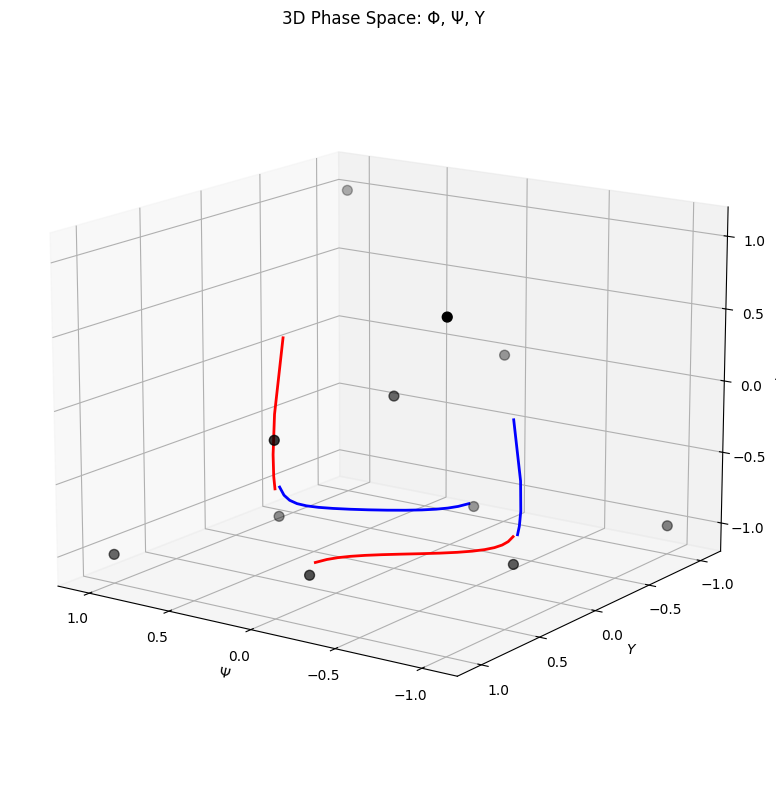

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# -------------------- 3D Dynamics --------------------
def dynamicsStateSpace3D(Phi,Psi,Y):


    phi = Phi/np.sqrt(1-Phi**2)
    dPsi = -3*Y*Psi*np.sqrt(1-Psi**2) - 2*(1-Psi**2)**1.5*np.exp(phi)*(np.exp(phi)-1)
    dPhi = (1-Phi**2)**1.5 * Psi / np.sqrt(1-Psi**2)
    dY = -Y**2/np.sqrt(1-Y**2) - 1/3 * (Psi**2/np.sqrt(1-Psi**2) - (np.exp(phi)-1)**2) * (1-Y**2/np.sqrt(1-Y**2))**(-3/2)

    return np.array([dPhi, dPsi, dY])

def dynamics_odeint3D(t, state):
    Phi, Psi, Y = state
    #if abs(Phi) >= 0.999 or abs(Psi) >= 0.999 or abs(Y) >= 0.999: # stops integrating for dY when it blows up or divide by 0
       # return [0,0,0]
    eps = 1e-6
    Phi = np.clip(Phi, -1+eps,1-eps)
    Psi = np.clip(Psi,-1+eps,1-eps)
    Y = np.clip(Y,-1+eps,1-eps)
    return dynamicsStateSpace3D(Phi,Psi,Y)

#  Fixed points 
manual_FP = np.array([[0,0,0],[-1,0,0.72],[-1,0,-0.72],[-1,1,1],[-1,-1,-1],[1,1,-1],[1,-1,1],[0,0,-1],[0,0,1],[-1,-0.72,0],[-1,0.72,0]]) 

# Slightly perturbed ICs for separatrices in 3D
Sep_ICs_exp = [[-1+0.2,-0.75+0.02,0+0.02],[-1+0.2,0.75-0.02,0+0.02],[-1+0.2,0+0.01,0.8-0.02]]
Sep_ICs_con = [[-1+0.2,-0.75+0.02,0-0.02],[-1+0.2,0.75-0.02,0-0.02],[-1+0.2,0+0.01,-0.8+0.02]]


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot fixed points
ax.scatter(manual_FP[:,1], manual_FP[:,2], manual_FP[:,0], color='k', s=50)

# Integrate separatrices forward/backward in time
for ic in Sep_ICs_exp:
    sol = solve_ivp(dynamics_odeint3D, [0,100], ic, t_eval=np.linspace(0,100,400), rtol=1e-6, atol=1e-6)
    ax.plot(sol.y[1], sol.y[2], sol.y[0], color='r', linewidth=2)

for ic in Sep_ICs_con:
    sol = solve_ivp(dynamics_odeint3D, [100,0], ic, t_eval=np.linspace(100,0,400), rtol=1e-6, atol=1e-6)
    ax.plot(sol.y[1], sol.y[2], sol.y[0], color='b', linewidth=2)

# Axes labels and limits
ax.set_xlabel(rf"$\Psi$")
ax.set_ylabel(r"$Y$")
ax.set_zlabel(rf"$\Phi$")
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_zlim([-1.2,1.2])
ax.set_title("3D Phase Space: Φ, Ψ, Y")
ax.view_init(elev=15, azim=125)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2936/2178308454.py:16: RuntimeWarning: invalid value encountered in scalar power
  dY = -Y**2/np.sqrt(1-Y**2) - 1/3 * (Psi**2/np.sqrt(1-Psi**2) - (np.exp(phi)-1)**2) * (1-Y**2/np.sqrt(1-Y**2))**(-3/2)


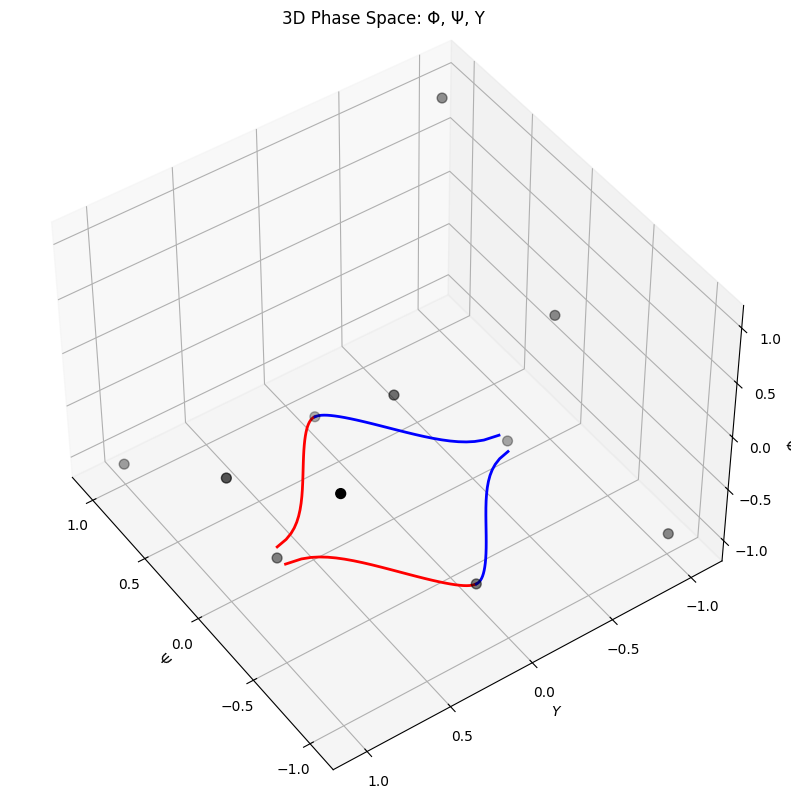

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -------------------- 3D Dynamics --------------------
def dynamicsStateSpace3D(Phi,Psi,Y):
    eps = 1e-6
    # small clipping only to avoid sqrt(0)
    Phi = np.clip(Phi, -1+eps,1-eps)
    Psi = np.clip(Psi,-1+eps,1-eps)
    Y = np.clip(Y,-1+eps,1-eps)

    phi = Phi/np.sqrt(1-Phi**2)
    dPsi = -3*Y*Psi*np.sqrt(1-Psi**2) - 2*(1-Psi**2)**1.5*np.exp(phi)*(np.exp(phi)-1)
    dPhi = (1-Phi**2)**1.5 * Psi / np.sqrt(1-Psi**2)
    dY = -Y**2/np.sqrt(1-Y**2) - 1/3 * (Psi**2/np.sqrt(1-Psi**2) - (np.exp(phi)-1)**2) * (1-Y**2/np.sqrt(1-Y**2))**(-3/2)

    return np.array([dPhi, dPsi, dY])

def dynamics_odeint3D(t, state):
    # no freezing: let dynamics evolve even near ±1
    Phi, Psi, Y = state
    return dynamicsStateSpace3D(Phi, Psi, Y)

# -------------------- Jacobian --------------------
def numerical_jacobian_3D(F, x, h=1e-6):
    x = np.array(x, dtype=float)
    J = np.zeros((3,3))
    for i in range(3):
        dx = np.zeros(3)
        dx[i] = h
        f1 = np.array(F(*(x + dx)))
        f0 = np.array(F(*(x - dx)))
        J[:, i] = (f1 - f0)/(2*h)
    return J

# -------------------- Fixed points --------------------
manual_FP = np.array([
    [0,0,0], [-1,0,0.72], [-1,0,-0.72], [-1,1,1], [-1,-1,-1],
    [1,1,-1], [1,-1,1], [0,0,-1], [0,0,1], [-1,-0.72,0], [-1,0.72,0]
])

# -------------------- Generate initial ICs along unstable manifold --------------------
def unstable_IC_3D(fp, delta=1e-3, forward=True):
    J = numerical_jacobian_3D(dynamicsStateSpace3D, fp)
    eigvals, eigvecs = np.linalg.eig(J)
    real_parts = np.real(eigvals)
    
    if forward:
        idx = np.argmax(real_parts)  # forward unstable
    else:
        idx = np.argmin(real_parts)  # backward unstable
    vec = np.real(eigvecs[:, idx])
    vec /= np.linalg.norm(vec)
    
    ic = np.array(fp) + delta*vec
    return ic

# pick the two FPs with separatrices to 0,0,0
fp1 = [-1,-0.72,0]
fp2 = [-1,0.72,0]

Sep_ICs_exp = [
    unstable_IC_3D(fp1, forward=True),
    unstable_IC_3D(fp2, forward=True)
]

Sep_ICs_con = [
    unstable_IC_3D(fp1, forward=False),
    unstable_IC_3D(fp2, forward=False)
]

# -------------------- Plotting --------------------
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# plot fixed points
ax.scatter(manual_FP[:,1], manual_FP[:,2], manual_FP[:,0], color='k', s=50)

# integrate separatrices forward (expanding)
for ic in Sep_ICs_exp:
    sol = solve_ivp(dynamics_odeint3D, [0,50], ic, t_eval=np.linspace(0,50,400), rtol=1e-6, atol=1e-6)
    ax.plot(sol.y[1], sol.y[2], sol.y[0], color='r', linewidth=2)

# integrate separatrices backward (contracting)
for ic in Sep_ICs_con:
    sol = solve_ivp(dynamics_odeint3D, [50,0], ic, t_eval=np.linspace(50,0,400), rtol=1e-6, atol=1e-6)
    ax.plot(sol.y[1], sol.y[2], sol.y[0], color='b', linewidth=2)

# axes labels and limits
ax.set_xlabel(r"$\Psi$")
ax.set_ylabel(r"$Y$")
ax.set_zlabel(r"$\Phi$")
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_zlim([-1.2,1.2])
ax.set_title("3D Phase Space: Φ, Ψ, Y")
ax.view_init(elev=45, azim=145)
plt.tight_layout()
plt.show()
